In [ ]:
import numpy as np
import pandas as pd

import re

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras import regularizers

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mia.jensen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mia.jensen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Collection

In [17]:
df = pd.read_csv("../../Datasets/sentiment_analysis/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
df = df.drop(columns=["id"])
display(df.head(3))  

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."


### Data Preprocessing - Cleaning, Lematisation, Stemming, Stopwords

In [18]:
# clean text 
#  - remove HTML tags
#  - remove special characters
#  - convert to lowercase

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

In [ ]:
# lemmatise words (reduce words to base forms)

nltk.download('punkt')
nltk.download('wordnet')

lem = WordNetLemmatizer()

def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lem.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(words)]
    return ' '.join(lemmatized_words)

df['lemmatized_review'] = df['cleaned_review'].apply(lemmatize_text)

In [39]:
# remove stop words

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words_no_special_chars = {re.sub(r'[^a-zA-Z\s]', '', word) for word in stop_words}
all_stop_words = stop_words.union(stop_words_no_special_chars)

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['final_review'] = df['lemmatized_review'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mia.jensen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
# Data train test split

X = df["final_review"].to_numpy()
y = df["sentiment"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training Data Input Shape: ", X_train.shape)
print("Training Data Output Shape: ", y_train.shape)
print("Testing Data Input Shape: ", X_test.shape)
print("Testing Data Output Shape: ", y_test.shape)

Training Data Input Shape:  (17500,)
Training Data Output Shape:  (17500,)
Testing Data Input Shape:  (7500,)
Testing Data Output Shape:  (7500,)


In [44]:
# tokenise text corpus

vocab_size = 10000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(X_train)

print("Number of Documents: ", tokenizer.document_count)
print("Number of Words: ", tokenizer.num_words)

Number of Documents:  17500
Number of Words:  10000


In [66]:
# convert reviews into number sequences, with padding
# Sequences greater than seq_length will be truncated. Sequences less than seq_length will be padded with zeros.

seq_length = 200

train_seqs = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seqs, maxlen=seq_length, padding='post', truncating='post')

test_seqs = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seqs, maxlen=seq_length, padding='post', truncating='post')

### Model - Build, Train, Evaluate

In [67]:
# build model

model = Sequential()

embedding_dim = 128
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,543,425
Trainable params: 1,543,425
Non-trainable params: 0
_________________________________________________________________


In [68]:
# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [69]:
# train model

history = model.fit(
    train_padded, y_train, 
    epochs=30, 
    batch_size=64,
    validation_data=(test_padded, y_test), 
    callbacks=[EarlyStopping(patience=10)]
)

Epoch 1/30
274/274 [==============================] - 556s 2s/step - loss: 0.4923 - accuracy: 0.7548 - val_loss: 0.3837 - val_accuracy: 0.8587
Epoch 2/30
274/274 [==============================] - 709s 3s/step - loss: 0.2621 - accuracy: 0.8995 - val_loss: 0.3150 - val_accuracy: 0.8724
Epoch 3/30
274/274 [==============================] - 708s 3s/step - loss: 0.1869 - accuracy: 0.9337 - val_loss: 0.4172 - val_accuracy: 0.8472
Epoch 4/30
274/274 [==============================] - 719s 3s/step - loss: 0.1892 - accuracy: 0.9306 - val_loss: 0.3975 - val_accuracy: 0.8524
Epoch 5/30
274/274 [==============================] - 753s 3s/step - loss: 0.1400 - accuracy: 0.9515 - val_loss: 0.5586 - val_accuracy: 0.8453
Epoch 6/30
274/274 [==============================] - 789s 3s/step - loss: 0.1050 - accuracy: 0.9649 - val_loss: 0.5081 - val_accuracy: 0.8496
Epoch 7/30
274/274 [==============================] - 768s 3s/step - loss: 0.0885 - accuracy: 0.9710 - val_loss: 0.5250 - val_accuracy: 0.8531

,loss,accuracy,val_loss,val_accuracy
0,0.693431,0.513029,0.691907,0.510000
1,0.677048,0.544629,0.689488,0.513200
2,0.657752,0.554343,0.694571,0.512400
3,0.626547,0.564286,0.697840,0.536400
4,0.610869,0.629486,0.708342,0.506533
5,0.642868,0.569714,0.701813,0.506400
6,0.601740,0.621143,0.716304,0.711333


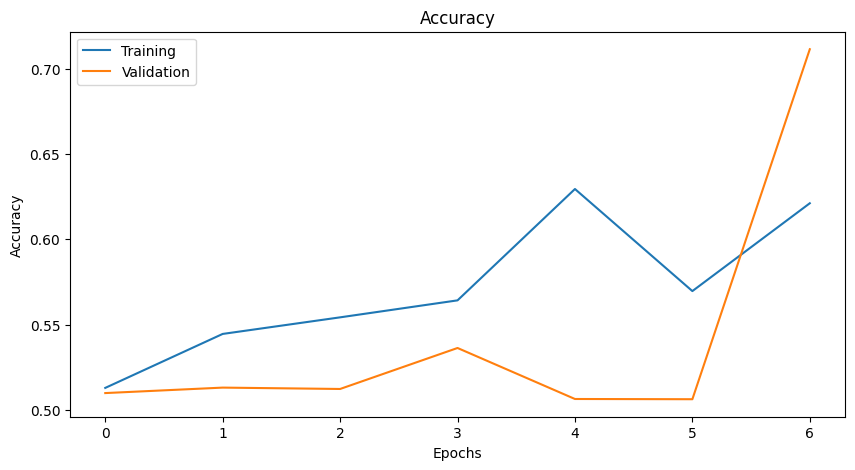

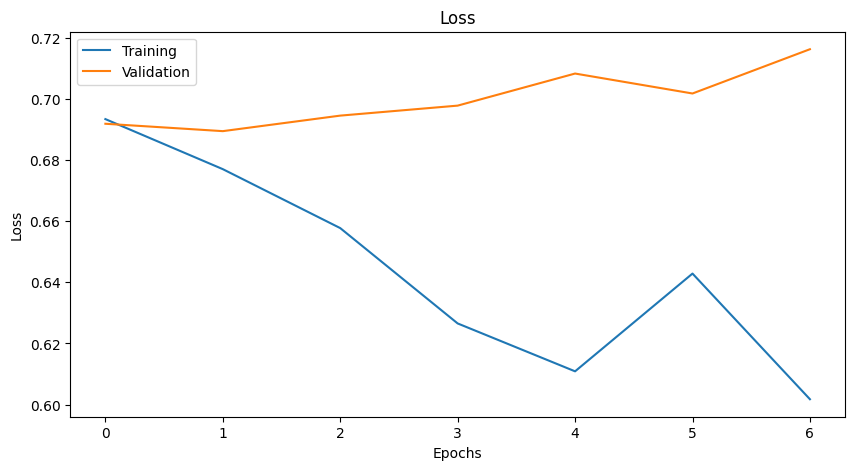

In [61]:
df_metrics = pd.DataFrame(history.history)
display(df_metrics)

plt.figure(figsize=(10,5))
plt.plot(df_metrics.index, df_metrics.accuracy)
plt.plot(df_metrics.index, df_metrics.val_accuracy)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df_metrics.index, df_metrics.loss)
plt.plot(df_metrics.index, df_metrics.val_loss)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()